# IMDB电影情感分析

本案例使用来自互联网电影数据库（IMDB）的原始文本数据，而不是使用Keras 内置的已经预先分词的IMDB 数据。从头开始进行文本的预处理，分词，词嵌入等操作。使用循环神经网络学习电影评论的文字内容，将其划分为正面评论或负面评论。

# 读入数据

In [1]:
import re
import nltk 
import os
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM

In [13]:
reviews = pd.read_csv('labeledTrainData.tsv', delimiter="\t")

In [14]:
reviews.drop('id',axis=1, inplace=True)

In [15]:
reviews

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...
...,...,...
24995,0,It seems like more consideration has gone into...
24996,0,I don't believe they made this film. Completel...
24997,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,0,This 30 minute documentary Buñuel made in the ...


# 数据预处理

In [16]:
# 将字母统一转换为小写
reviews['review'] = reviews['review'].apply(lambda x: x.lower())

# 除字母数字单引号之外的所有字符都去掉
reviews['review'] = reviews['review'].apply((lambda x: re.sub('[^\w\s\']','',x)))

#去除停用词
stops = set(stopwords.words("english"))
def delWord(x):
    wordList = x.split()
    cleanWord = [w for w in wordList if not w in stops]
    newSentence = " ".join(cleanWord)
    return newSentence

reviews['review'] = reviews['review'].apply(lambda x: delWord(x))

查看预处理之后的文本：

In [17]:
reviews.head()

,sentiment,review
0,1,stuff going moment mj i've started listening m...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious 80's ...


查看文本长度的统计信息：

In [18]:
reviews['length'] = reviews['review'].apply(len)
reviews.length.describe()

count    25000.000000
mean       852.045920
std        659.638886
min         27.000000
25%        440.000000
50%        624.000000
75%       1039.000000
max       9302.000000
Name: length, dtype: float64

由此选择输入特征的最大长度为1000，长度不足补零，长度超过的文本编码时裁剪。

# 分词

In [19]:
labels = np.array(reviews.sentiment)
texts = np.array(reviews.review)

In [20]:
maxlen = 1000 #在1000个单词后截断评论
training_samples = 10000 #在10000个样本上训练
validation_samples = 2000  #在2000个样本上测试
max_words = 10000   #只考虑数据集中前10000个最常见的词

tokenizer = Tokenizer(num_words= max_words) #创建类，对文本语料中的最常见的进行向量化，其实这个类同时可以进行预处理的工作
tokenizer.fit_on_texts(texts)   # 建立Token字典，整数索引单词
sequences = tokenizer.texts_to_sequences(texts)# 根据Token字典的映射，将评论文本中单词进行数值编码

word_index = tokenizer.word_index    #字典
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)  # 统一每条评论文本的长度，不足以0补齐
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 129347 unique tokens.
Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000,)


将数据打乱，并划分数据集和训练集：

In [30]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

查看处理好的数据：

In [33]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# GloVe词嵌入

使用已经下载好的GloVe词典，构建一个将单词（字符串）映射为其100维向量表示（数值向量）的索引。

In [34]:
glove_dir = './glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


读入的`embeddings_index`是一个关于400000个字的向量表示。然后得到之前数据集中得到的`word_index`词典中单词的GloVe词表示。

In [37]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

`embedding_matrix`是文本中这10000个单词的向量表示。

# RNN模型训练

直接使用嵌入层，进行RNN模型训练。

In [25]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))#添加嵌入层
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 700, 100)          1000000   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,033,473
Trainable params: 1,033,473
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 219s 22ms/sample - loss: 0.6998 - acc: 0.5091 - val_loss: 0.6904 - val_acc: 0.5155
Epoch 2/10
10000/10000 [==============================] - 176s 18ms/sample - loss: 0.6833 - acc: 0.5541 - val_loss: 0.6721 - val_acc: 0.5620
Epoch 3/10
10000/10000 [==============================] - 169s 17ms/sample - loss: 0.6515 - acc: 0.5966 - val_loss: 0.6499 - val_acc: 0.5770
Epoch 4/10
10000/10000 [==============================] - 154s 15ms/sample - loss: 0.6048 - acc: 0.6568 - val_loss: 0.6204 - val_acc: 0.6380
Epoch 5/10
10000/10000 [==============================] - 147s 15ms/sample - loss: 0.5551 - acc: 0.7094 - val_loss: 0.6066 - val_acc: 0.6500
Epoch 6/10
10000/10000 [==============================] - 146s 15ms/sample - loss: 0.5406 - acc: 0.7240 - val_loss: 0.6135 - val_acc: 0.6485
Epoch 7/10
10000/10000 [==============================] - 148s 15ms/sample - loss: 0.5188 - acc: 0.7428 -

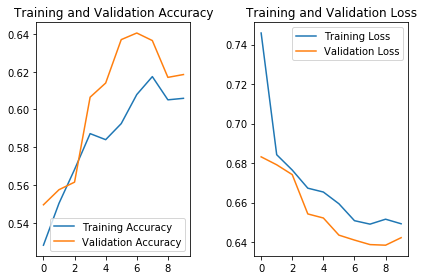

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

使用GloVe词向量的RNN模型：

In [31]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [32]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 111s 11ms/sample - loss: 0.7458 - acc: 0.5281 - val_loss: 0.6832 - val_acc: 0.5495
Epoch 2/10
10000/10000 [==============================] - 112s 11ms/sample - loss: 0.6843 - acc: 0.5503 - val_loss: 0.6792 - val_acc: 0.5575
Epoch 3/10
10000/10000 [==============================] - 154s 15ms/sample - loss: 0.6765 - acc: 0.5682 - val_loss: 0.6742 - val_acc: 0.5615
Epoch 4/10
10000/10000 [==============================] - 145s 14ms/sample - loss: 0.6673 - acc: 0.5872 - val_loss: 0.6543 - val_acc: 0.6065
Epoch 5/10
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.6654 - acc: 0.5840 - val_loss: 0.6523 - val_acc: 0.6140
Epoch 6/10
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.6595 - acc: 0.5925 - val_loss: 0.6436 - val_acc: 0.6370
Epoch 7/10
10000/10000 [==============================] - 143s 14ms/sample - loss: 0.6509 - acc: 0.6079 -

使用LSTM模型和GloVe词嵌入：

In [33]:
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 700, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,121,409
Trainable params: 121,409
Non-trainable params: 1,000,000
_________________________________________________________________


In [34]:
model2.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history_LSTM = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 359s 36ms/sample - loss: 0.5996 - acc: 0.6797 - val_loss: 0.5086 - val_acc: 0.7520
Epoch 2/10
10000/10000 [==============================] - 369s 37ms/sample - loss: 0.5216 - acc: 0.7460 - val_loss: 0.5126 - val_acc: 0.7625
Epoch 3/10
10000/10000 [==============================] - 383s 38ms/sample - loss: 0.4763 - acc: 0.7713 - val_loss: 0.4787 - val_acc: 0.7685
Epoch 4/10
10000/10000 [==============================] - 384s 38ms/sample - loss: 0.4483 - acc: 0.7942 - val_loss: 0.6026 - val_acc: 0.6980
Epoch 5/10
10000/10000 [==============================] - 400s 40ms/sample - loss: 0.4035 - acc: 0.8163 - val_loss: 0.4082 - val_acc: 0.8140
Epoch 6/10
10000/10000 [==============================] - 401s 40ms/sample - loss: 0.3851 - acc: 0.8320 - val_loss: 0.3942 - val_acc: 0.8195
Epoch 7/10
10000/10000 [==============================] - 455s 45ms/sample - loss: 0.3683 - acc: 0.8371 -

可以看出长短时记忆模型可以很快达到比较好的效果。